In [216]:
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numdifftools as nd

In [217]:
df = pd.read_csv('./../data/price_elasticity_data.csv')

In [218]:
df.isnull().sum()

Product              0
Menu_Price           0
Pizza_Count          0
Profit_Percentage    0
dtype: int64

rename columns

In [219]:
names = {'Menu_Price': 'unit_price', 'Pizza_Count': 'quantity', 'Profit_Percentage': 'profit_percentage'}
df.rename(columns=names, inplace=True)

# calculate additional features

In [220]:
df['gross_margin'] = df['profit_percentage'] / 100
df['gross_profit'] = df['unit_price'] * (1 - df['gross_margin'])
df['cost'] = df['unit_price'] - df['gross_profit']
df['invoiced_sales'] = df['unit_price'] * df['quantity']
df['invoiced_gp'] = df['gross_profit'] * df['quantity']

# Subset the dataframe for 'Communita' product and create a copy

In [221]:
communita_df = df[df['Product'] == 'Communita'].copy()
communita_df

,Product,unit_price,quantity,profit_percentage,gross_margin,gross_profit,cost,invoiced_sales,invoiced_gp
71,Communita,7.25,3.402471,24.943828,0.249438,5.441572,1.808428,24.667917,18.514794
72,Communita,7.75,3.477570,26.713227,0.267132,5.679725,2.070275,26.951164,19.751639
73,Communita,8.88,3.254277,31.495838,0.314958,6.083170,2.796830,28.897983,19.796321
74,Communita,9.35,3.355994,31.560711,0.315607,6.399073,2.950927,31.378539,21.475249
75,Communita,9.67,3.359889,32.743797,0.327438,6.503675,3.166325,32.490124,21.851624
...,...,...,...,...,...,...,...,...,...
151,Communita,16.32,3.254308,49.061000,0.490610,8.313245,8.006755,53.110300,27.053856
152,Communita,16.49,3.139681,49.011439,0.490114,8.408014,8.081986,51.773335,26.398479
153,Communita,16.50,3.149412,48.987274,0.489873,8.417100,8.082900,51.965300,26.508916
154,Communita,16.99,3.140224,49.472921,0.494729,8.584551,8.405449,53.352414,26.957416


In [222]:
communita_df.isnull().sum()

Product              0
unit_price           0
quantity             0
profit_percentage    0
gross_margin         0
gross_profit         0
cost                 0
invoiced_sales       0
invoiced_gp          0
dtype: int64

In [223]:
communita_df['unit_price'].max()

np.float64(25.64)

In [224]:
communita_df['quantity'].sum()

np.float64(281.799705092)

In [225]:
communita_df['invoiced_sales'].sum()

np.float64(3614.7951788701257)

In [226]:
communita_df['invoiced_gp'].sum()

np.float64(2033.4767613498261)

In [227]:
communita_df['quantity'].mean()

np.float64(3.315290648141177)

In [228]:
communita_df['unit_price'].mean()

np.float64(12.886705882352942)

In [229]:
def identify_outliers(df, column):
    """
     Identify outliers in a specified column of a DataFrame using the 
     Interquartile Range (IQR) method.
     
     The function calculates the first quartile (Q1) and the third quartile 
     (Q3) of the specified column. The interquartile range (IQR) is then 
     computed as the difference between Q3 and Q1.
    
     Outliers are defined as data points that fall below Q1 - 1.5 * IQR or 
     above Q3 + 1.5 * IQR. The function returns the rows containing these  
     outliers along with the calculated lower and upper bounds.

    :param df: 
    :param column: 
    :return: tuple: A tuple containing:
        - pandas.DataFrame: A DataFrame containing the rows identified as outliers.
        - float: The lower bound for identifying outliers.
        - float: The upper bound for identifying outliers.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)], lower_bound, upper_bound

In [230]:
communita_outliers, comm_lower, comm_upper = identify_outliers(df[df['Product'] == 'Communita'], 'unit_price')

remove high side outliers

In [231]:
data_no_outliers = communita_df.drop(communita_outliers[communita_outliers['unit_price'] > comm_upper].index)

remove low side outliers

In [232]:
communita_df = data_no_outliers.drop(communita_outliers[communita_outliers['unit_price'] < comm_lower].index)

### Display the statistics

In [233]:
print(f"Individuale Price Statistics without High Side Outliers:\n{communita_df}")
print(f"\nCommunita Price Statistics without High Side Outliers:\n{communita_df}")

Individuale Price Statistics without High Side Outliers:
       Product  unit_price  quantity  profit_percentage  gross_margin  \
72   Communita        7.75  3.477570          26.713227      0.267132   
73   Communita        8.88  3.254277          31.495838      0.314958   
74   Communita        9.35  3.355994          31.560711      0.315607   
75   Communita        9.67  3.359889          32.743797      0.327438   
76   Communita        9.93  3.326368          33.301388      0.333014   
..         ...         ...       ...                ...           ...   
150  Communita       16.00  3.164765          49.260706      0.492607   
151  Communita       16.32  3.254308          49.061000      0.490610   
152  Communita       16.49  3.139681          49.011439      0.490114   
153  Communita       16.50  3.149412          48.987274      0.489873   
154  Communita       16.99  3.140224          49.472921      0.494729   

     gross_profit      cost  invoiced_sales  invoiced_gp  
72     

# Fit linear regression model

In [234]:
# extract x and y values
x_value = communita_df['unit_price']
y_value = communita_df['quantity']

# ensure x and y are of the same length
assert len(x_value) == len(y_value), "x and y must have the same length"

# add a constant to the independent variable (unit_price)
X = add_constant(x_value)

# fit the regression model
model = sm.OLS(y_value, X)
communita_result = model.fit()

# print the summary of the regression model
print(communita_result.summary())

                            OLS Regression Results                            
Dep. Variable:               quantity   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     183.9
Date:                Wed, 07 Aug 2024   Prob (F-statistic):           1.53e-22
Time:                        10:33:17   Log-Likelihood:                 130.66
No. Observations:                  83   AIC:                            -257.3
Df Residuals:                      81   BIC:                            -252.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8237      0.038    101.431      0.0

# Analysis
Here’s a detailed analysis of the OLS regression results, having removed outliers:

# Get the predicted values

In [235]:
predictions = communita_result.predict(X)

Add predictions to the dataframe

In [236]:
communita_df['predictions'] = predictions

Create a scatter plot with the regression line

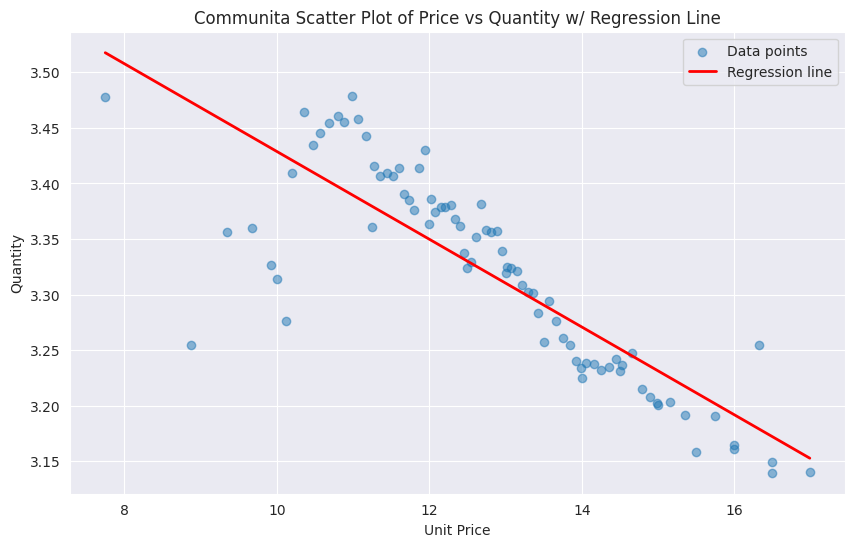

In [237]:
plt.figure(figsize=(10, 6))
plt.scatter(
    communita_df['unit_price'], 
    communita_df['quantity'], 
    alpha=0.5, 
    label='Data points'
)
plt.plot(
    communita_df['unit_price'], 
    predictions, 
    color='red', 
    linewidth=2, 
    label='Regression line'
)
plt.title('Communita Scatter Plot of Price vs Quantity w/ Regression Line')
plt.xlabel('Unit Price')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.savefig('./../plots/communita_slr_no_outliers_scatter_plot_with_regression_line')
plt.show()

The regression line represents the relationship between unit price and quantity demanded as modelled by simple linear regression. We can use it to derive our Price elasticity of demand (PED)

The regression line can be expressed as:
$$\text{Quantity} = \alpha + \beta \times \text{Price}$$

where:
- $\alpha$ is the intercept of the line.
- $\beta$ is the slope of the regression line

From our regression summary we know that:
- $\alpha = $
- $\beta = $

In [238]:
mean_cost = np.mean(communita_df['cost'])

# Access alpha and beta directly from the fitted model

In [239]:
alpha = communita_result.params['const']
alpha

np.float64(3.823729311509548)

In [240]:
beta = communita_result.params['unit_price']
beta

np.float64(-0.039492766265993046)

# Calculate mean price and mean quantity

In [241]:
communita_mean_price = np.mean(communita_df['unit_price'])
communita_mean_quantity = np.mean(communita_df['quantity'])

# Calculate PED

In [242]:
ped = beta * (communita_mean_price / communita_mean_quantity)
print(f'Price Elasticity of Demand: {ped}')

Price Elasticity of Demand: -0.1523560773619287


Communita is less elastic and individuale

# plot profit curve
we want to know at what price point we maximise gross profit

In [243]:
# Calculate the gross profit based on the predictions
communita_df['gross_profit_predictions'] = (communita_df['unit_price'] - communita_df['cost']) * communita_df['predictions']

# Find the price that maximizes gross profit

In [244]:
optimal_price = communita_df.loc[communita_df['gross_profit_predictions'].idxmax(), 'unit_price']
max_gross_profit = communita_df['gross_profit_predictions'].max()
optimal_quantity = communita_df.loc[communita_df['gross_profit_predictions'].idxmax(), 'predictions']

In [245]:
def gross_profit_function(price):
    """
    Define the gross profit function based on the regression model
    :param price: 
    :return: 
    """
    return (price - mean_cost) * (alpha + beta * price)

Calculate the first derivative (slope) at the optimal price

In [246]:
derivative_function = nd.Derivative(gross_profit_function)
slope_at_optimal_price = derivative_function(optimal_price)

first derivative line, given point and slope

In [247]:
# fix_me
# Given point and slope
x1, y1 = 16.99, 27.06
slope = 2.7032873208187955
intercept = y1 - slope * x1  # Calculate y-intercept
x_vals = np.linspace(communita_df['unit_price'].min(), communita_df['unit_price'].max(), 100)  # Generate x values for the line
y_vals = slope * x_vals + intercept  # calculate y values using the line equation

# Plot the original gross profit curve

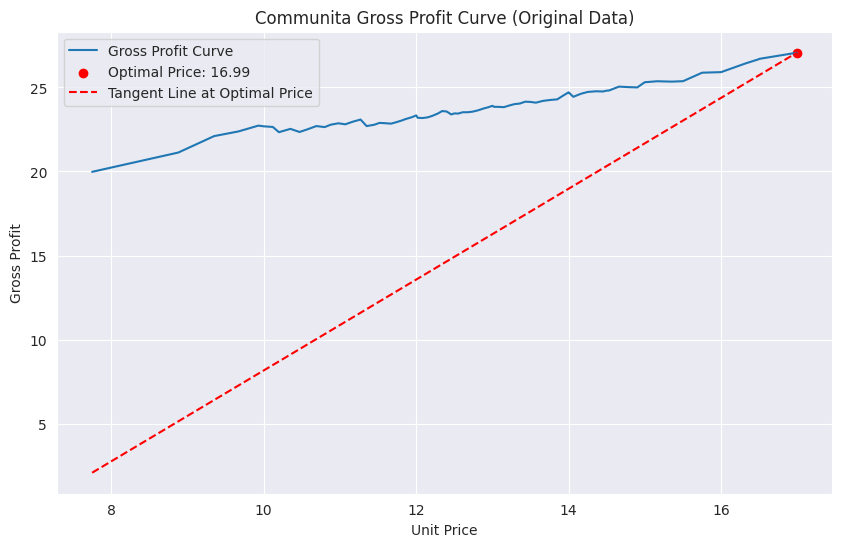

In [248]:
plt.figure(figsize=(10, 6))
plt.plot(
    communita_df['unit_price'], 
    communita_df['gross_profit_predictions'], 
    label='Gross Profit Curve'
)
plt.scatter(
    optimal_price, 
    max_gross_profit, 
    color='red', 
    label=f'Optimal Price: {optimal_price:.2f}'
)
plt.plot(
    x_vals, 
    y_vals, 
    color='red', 
    linestyle='--', 
    label=f'Tangent Line at Optimal Price'
)  # fix_me
plt.title('Communita Gross Profit Curve (Original Data)')
plt.xlabel('Unit Price')
plt.ylabel('Gross Profit')
plt.legend()
plt.grid(True)
plt.savefig('./../plots/communita_gp_curve')
plt.show()

Print the optimal price and slope at that point

In [249]:
print(f'Optimal Price (Original): {round(optimal_price, 2)}')
print(f'Optimal Quantity (Original): {round(optimal_quantity, 0)}')
print(f'Maximum Gross Profit: {round(max_gross_profit, 2)}')
print(f'Slope of the Gross Profit Function at Optimal Price: {slope_at_optimal_price}')

Optimal Price (Original): 16.99
Optimal Quantity (Original): 3.0
Maximum Gross Profit: 27.06
Slope of the Gross Profit Function at Optimal Price: 2.7032873208187955


# Analysis


# Extend the predictions
Create a new range of unit prices extending beyond the observed data

In [250]:
new_unit_prices = np.linspace(communita_df['unit_price'].min(), 100, 100)
new_X = sm.add_constant(new_unit_prices)

Predict the quantities for the new range of unit prices

In [251]:
new_predictions = communita_result.predict(new_X)

Calculate the gross profit for the new unit prices. Assuming cost remains constant, using the mean cost from the original data

In [252]:
new_gross_profits = (new_unit_prices - mean_cost) * new_predictions

Find the price that maximizes gross profit

In [253]:
max_index = np.argmax(new_gross_profits)
optimal_price_extended = new_unit_prices[np.argmax(new_gross_profits)]
max_gross_profit_extended = new_gross_profits.max()
optimal_quantity_extended = new_predictions[max_index]

In [254]:
def extended_gross_profit_function(price):
    """
    Define the gross profit function based on the regression model
    :param price: 
    :return: 
    """
    return (price - mean_cost) * (alpha + beta * price)

Calculate the first derivative (slope) at the optimal price

In [255]:
derivative_function = nd.Derivative(extended_gross_profit_function)
slope_at_optimal_price_extended = derivative_function(optimal_price_extended)

# Plot the extended gross profit curve

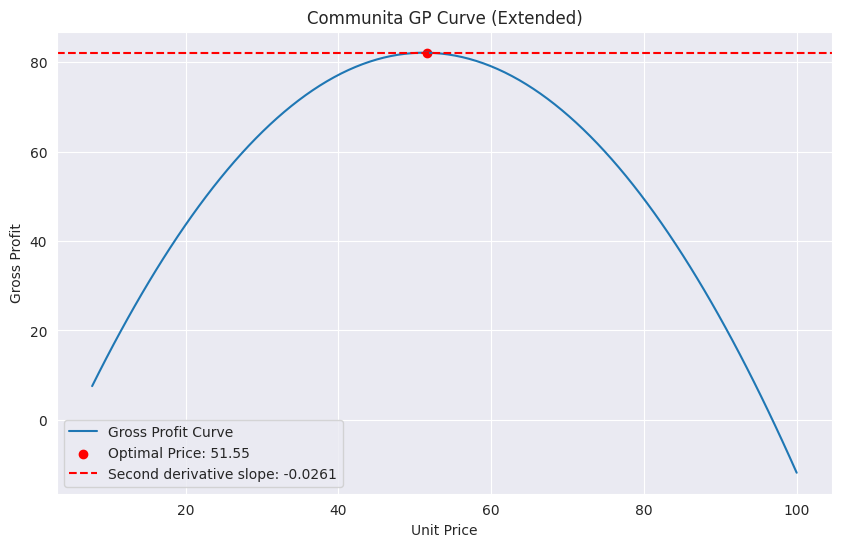

In [256]:
plt.figure(figsize=(10, 6))
plt.plot(
    new_unit_prices, 
    new_gross_profits, 
    label='Gross Profit Curve'
)
plt.scatter(
    optimal_price_extended, 
    max_gross_profit_extended, 
    color='red', 
    label=f'Optimal Price: {optimal_price_extended:.2f}'
)
plt.axhline(
    y=max_gross_profit_extended, 
    color='red', 
    linestyle='--', 
    label=f'Second derivative slope: {slope_at_optimal_price_extended:.4f}'
)
plt.title('Communita GP Curve (Extended)')
plt.xlabel('Unit Price')
plt.ylabel('Gross Profit')
plt.legend()
plt.grid(True)
plt.savefig('./../plots/communita_ext_gp_curve')
plt.show()

# Analysis
the optimal price is significantly reduced by excluding outliers. This seems more realistic


# Print the optimal price and maximum gross profit

In [257]:
print(f'Optimal Price (Extended): {round(optimal_price_extended, 2)}')
print(f'Optimal Quantity (Extended): {round(optimal_quantity_extended, 2)}')
print(f'Maximum Gross Profit (Extended): {max_gross_profit_extended}')
print(f'Slope of the Gross Profit Function at Optimal Price (Extended): {slope_at_optimal_price_extended}')

Optimal Price (Extended): 51.55
Optimal Quantity (Extended): 1.79
Maximum Gross Profit (Extended): 82.13665673089957
Slope of the Gross Profit Function at Optimal Price (Extended): -0.02609365833877807


# Analysis
So, on the face of it, the optimal price point is 58.78 which is confirmed by the slope of the first derivative, which is very close to 0. 

However, because we're making predictions outside the dataset, it can only be considered a hypothesis at this point. We have no data to substantiate it. We should set up an experiment to gather more data about sales quantities at higher price points.

- Hypothesis ($H_1$): The optimal unit price that maximises gross profit is 58.78
- Null Hypothesis ($H_0$): The optimal unit price that maximises gross profit is different from 58.78

In [258]:
# todo: use plotly for the graphs we we can see price and quantity at different points using hover text, 
# todo: update analysis